In [1]:
!pip install -q pycocotools
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

import os
import json
import random
import numpy as np
from collections import Counter, defaultdict

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision.transforms import functional as F

import matplotlib.pyplot as plt
from PIL import Image

from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
ZIP_PATH = "/content/RMDS_Segmentation_Assignment.zip"  # change if needed
DATA_ROOT = "/content/data"

os.makedirs(DATA_ROOT, exist_ok=True)

!unzip -q "$ZIP_PATH" -d "$DATA_ROOT"

TRAIN_IMG_DIR = os.path.join(DATA_ROOT, "train-300", "data")
TRAIN_ANN_FILE = os.path.join(DATA_ROOT, "train-300", "labels.json")

VAL_IMG_DIR = os.path.join(DATA_ROOT, "validation-300", "data")
VAL_ANN_FILE = os.path.join(DATA_ROOT, "validation-300", "labels.json")

TEST_IMG_DIR = os.path.join(DATA_ROOT, "test-30")

print("Train images:", len(os.listdir(TRAIN_IMG_DIR)))
print("Val images:", len(os.listdir(VAL_IMG_DIR)))
print("Test images:", len([f for f in os.listdir(TEST_IMG_DIR) if f.endswith('.jpg')]))


Train images: 300
Val images: 300
Test images: 30


In [3]:
train_coco = COCO(TRAIN_ANN_FILE)
val_coco   = COCO(VAL_ANN_FILE)

# Our 4 target categories
TARGET_CLASS_NAMES = ["person", "cat", "sports ball", "book"]
target_cat_ids = train_coco.getCatIds(catNms=TARGET_CLASS_NAMES)
cats = train_coco.loadCats(target_cat_ids)

cat_id_to_name = {c["id"]: c["name"] for c in cats}
print("Target categories:", cat_id_to_name)


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Target categories: {1: 'person', 17: 'cat', 37: 'sports ball', 84: 'book'}


Train instance counts: Counter({1: 1137, 84: 128, 17: 27, 37: 18})
Val instance counts: Counter({1: 1026, 84: 129, 37: 36, 17: 22})


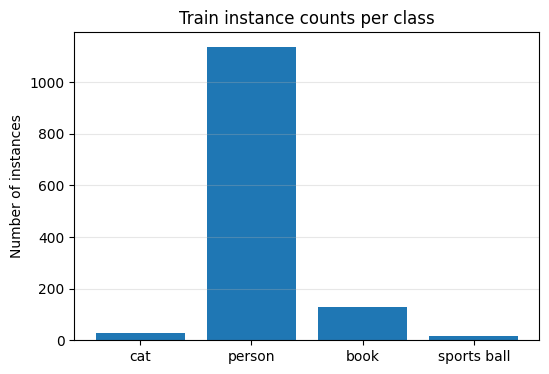

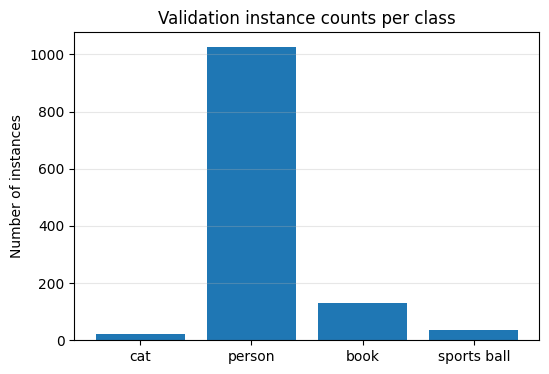

In [4]:
def get_instance_counts(coco, target_ids):
    counts = Counter()
    for ann in coco.dataset["annotations"]:
        cid = ann["category_id"]
        if cid in target_ids:
            counts[cid] += 1
    return counts

train_counts = get_instance_counts(train_coco, target_cat_ids)
val_counts   = get_instance_counts(val_coco, target_cat_ids)

print("Train instance counts:", train_counts)
print("Val instance counts:", val_counts)

# Plot
def plot_class_counts(counts, title):
    names = [cat_id_to_name[cid] for cid in counts.keys()]
    values = [counts[cid] for cid in counts.keys()]
    plt.figure(figsize=(6,4))
    plt.bar(names, values)
    plt.title(title)
    plt.ylabel("Number of instances")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

plot_class_counts(train_counts, "Train instance counts per class")
plot_class_counts(val_counts, "Validation instance counts per class")


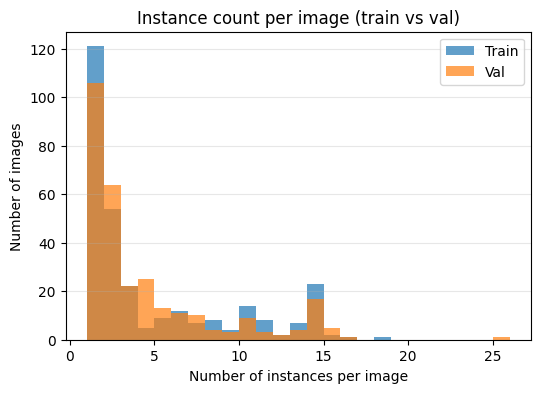

In [5]:
def instances_per_image(coco, target_ids):
    img_to_count = defaultdict(int)
    for ann in coco.dataset["annotations"]:
        if ann["category_id"] in target_ids:
            img_to_count[ann["image_id"]] += 1
    return list(img_to_count.values())

train_inst_per_img = instances_per_image(train_coco, target_cat_ids)
val_inst_per_img   = instances_per_image(val_coco, target_cat_ids)

plt.figure(figsize=(6,4))
plt.hist(train_inst_per_img, bins=range(1, max(train_inst_per_img)+2), alpha=0.7, label="Train")
plt.hist(val_inst_per_img, bins=range(1, max(val_inst_per_img)+2), alpha=0.7, label="Val")
plt.xlabel("Number of instances per image")
plt.ylabel("Number of images")
plt.title("Instance count per image (train vs val)")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


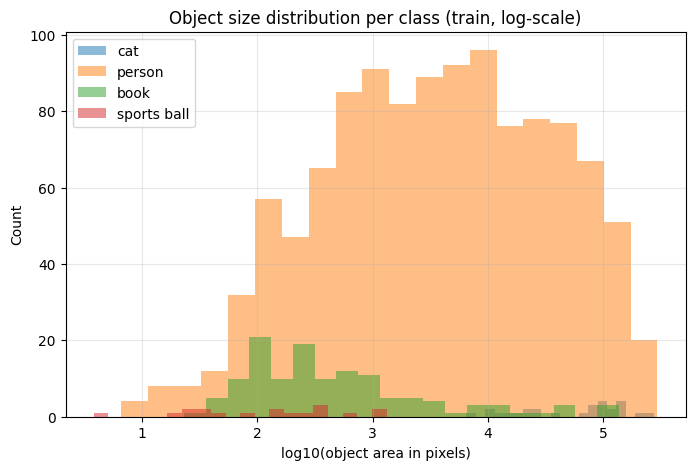

In [6]:
def get_area_per_class(coco, target_ids):
    areas = defaultdict(list)
    for ann in coco.dataset["annotations"]:
        cid = ann["category_id"]
        if cid in target_ids:
            x,y,w,h = ann["bbox"]
            area = w * h
            areas[cid].append(area)
    return areas

train_areas = get_area_per_class(train_coco, target_cat_ids)

plt.figure(figsize=(8,5))
for cid, arr in train_areas.items():
    if len(arr) == 0:
        continue
    plt.hist(np.log10(arr), bins=20, alpha=0.5, label=cat_id_to_name[cid])
plt.xlabel("log10(object area in pixels)")
plt.ylabel("Count")
plt.title("Object size distribution per class (train, log-scale)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


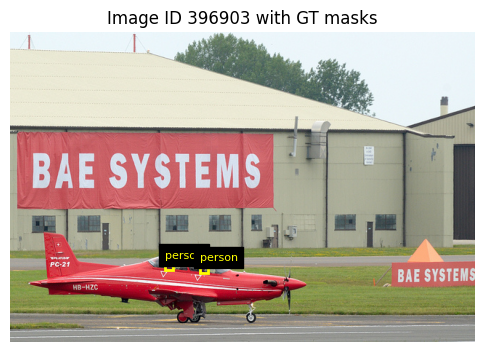

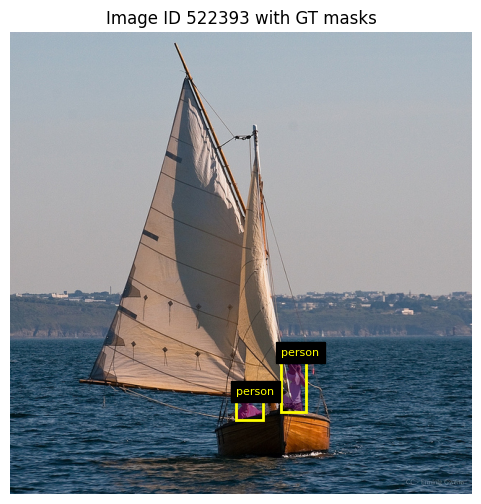

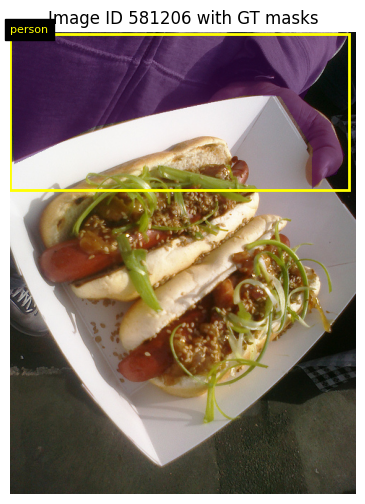

In [8]:
def show_image_with_gt(coco, img_dir, n_images=3):
    img_ids = coco.getImgIds()
    random.shuffle(img_ids)
    img_ids = img_ids[:n_images]

    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info["file_name"])
        image = np.array(Image.open(img_path).convert("RGB"))

        ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=target_cat_ids, iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        plt.figure(figsize=(6,6))
        plt.imshow(image)
        ax = plt.gca()

        for ann in anns:
            cid = ann["category_id"]
            mask = coco.annToMask(ann)
            # overlay mask
            ax.imshow(np.ma.masked_where(mask == 0, mask), alpha=0.5)
            # bbox
            x, y, w, h = ann["bbox"]
            rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='yellow', linewidth=2)
            ax.add_patch(rect)
            ax.text(x, y-2, cat_id_to_name[cid], color='yellow', fontsize=8, backgroundcolor='black')

        plt.axis('off')
        plt.title(f"Image ID {img_id} with GT masks")
        plt.show()

show_image_with_gt(train_coco, TRAIN_IMG_DIR, n_images=3)


In [9]:
class COCOSubsetDataset(Dataset):
    def __init__(self, img_dir, ann_file, target_cat_ids, transforms=None):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.transforms = transforms

        self.target_cat_ids = target_cat_ids
        # Map COCO category IDs → [1..num_classes] for our model (0 is background)
        self.cat_id_to_label = {cid: i+1 for i, cid in enumerate(self.target_cat_ids)}
        self.label_to_cat_id = {v: k for k, v in self.cat_id_to_label.items()}

        # image ids that contain at least one of target categories
        img_ids = set()
        for cid in self.target_cat_ids:
            img_ids.update(self.coco.getImgIds(catIds=[cid]))
        self.img_ids = sorted(list(img_ids))

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info["file_name"])

        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=[img_id], catIds=self.target_cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        masks = []

        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.target_cat_ids:
                continue

            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_id_to_label[cid])

            m = self.coco.annToMask(ann)
            masks.append(m)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks, axis=0), dtype=torch.uint8) if masks else torch.zeros((0, img.size[1], img.size[0]), dtype=torch.uint8)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id]),
            "area": torch.tensor([ann["area"] for ann in anns], dtype=torch.float32),
            "iscrowd": torch.tensor([ann.get("iscrowd", 0) for ann in anns], dtype=torch.int64),
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


In [10]:
class ComposeTransforms:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, image, target):
        if random.random() < self.p:
            image = F.hflip(image)
            if "boxes" in target:
                w = image.shape[2]
                boxes = target["boxes"]
                boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
                target["boxes"] = boxes
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
        return image, target

train_transforms = ComposeTransforms([
    ToTensor(),
    RandomHorizontalFlip(0.5),
])

val_transforms = ComposeTransforms([
    ToTensor(),
])


In [11]:
train_dataset = COCOSubsetDataset(TRAIN_IMG_DIR, TRAIN_ANN_FILE, target_cat_ids, transforms=train_transforms)
val_dataset   = COCOSubsetDataset(VAL_IMG_DIR, VAL_ANN_FILE, target_cat_ids, transforms=val_transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                          num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False,
                          num_workers=2, collate_fn=collate_fn)

len(train_dataset), len(val_dataset)


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


(300, 300)

In [12]:
num_classes = 1 + len(target_cat_ids)  # background + 4 classes

model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

# Replace box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes
)

# Replace mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    in_features_mask, hidden_layer, num_classes
)

model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [16]:
import torch.optim as optim

# OPTIONAL: freeze backbone to make training much faster
for param in model.backbone.parameters():
    param.requires_grad = False

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 3               # fewer epochs for speed
max_train_batches = 50       # limit batches per epoch (None = full)
max_val_batches = 20         # limit batches per epoch (None = full)

best_val_loss = float("inf")
save_path = "/content/maskrcnn_coco_subset_fast.pth"

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    # -------- TRAINING --------
    model.train()
    train_loss_sum = 0.0

    for batch_idx, (images, targets) in enumerate(train_loader):
        if max_train_batches is not None and batch_idx >= max_train_batches:
            break

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)          # returns loss dict in train mode
        losses = sum(loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss_sum += losses.item()

    avg_train_loss = train_loss_sum / (batch_idx + 1)
    print(f"  Train loss (subset): {avg_train_loss:.4f}")

    # -------- VALIDATION (subset, using loss) --------
    val_loss_sum = 0.0

    # We need TRAIN mode to get loss dict, but use no_grad so we don't backprop
    model.train()
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader):
            if max_val_batches is not None and batch_idx >= max_val_batches:
                break

            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)      # still returns loss dict
            losses = sum(loss_dict.values())
            val_loss_sum += losses.item()

    avg_val_loss = val_loss_sum / (batch_idx + 1)
    print(f"  Val loss (subset):   {avg_val_loss:.4f}")

    lr_scheduler.step()

    # -------- SAVE BEST MODEL --------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"   Saved new best model (val loss = {best_val_loss:.4f})")

print("\nTraining finished. Best model saved to:", save_path)


Epoch 1/3
  Train loss (subset): 0.6822
  Val loss (subset):   0.6301
   Saved new best model (val loss = 0.6301)

Epoch 2/3
  Train loss (subset): 0.6729
  Val loss (subset):   0.6237
   Saved new best model (val loss = 0.6237)

Epoch 3/3
  Train loss (subset): 0.5934
  Val loss (subset):   0.6260

Training finished. Best model saved to: /content/maskrcnn_coco_subset_fast.pth


In [17]:
def visualize_predictions(model, image_path, score_thresh=0.5):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_tensor = F.to_tensor(img).to(device)
    with torch.no_grad():
        output = model([img_tensor])[0]

    pred_boxes = output["boxes"].cpu().numpy()
    pred_labels = output["labels"].cpu().numpy()
    pred_scores = output["scores"].cpu().numpy()
    pred_masks = output["masks"].cpu().numpy()[:,0,:,:]

    keep = pred_scores >= score_thresh
    pred_boxes = pred_boxes[keep]
    pred_labels = pred_labels[keep]
    pred_scores = pred_scores[keep]
    pred_masks = pred_masks[keep]

    image_np = np.array(img)
    plt.figure(figsize=(6,6))
    plt.imshow(image_np)
    ax = plt.gca()

    for box, label, score, mask in zip(pred_boxes, pred_labels, pred_scores, pred_masks):
        y1, x1, y2, x2 = box[1], box[0], box[3], box[2]
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='lime', linewidth=2)
        ax.add_patch(rect)

        cid = target_cat_ids[label-1]
        name = cat_id_to_name[cid]
        ax.text(x1, y1-3, f"{name} {score:.2f}", color='lime', fontsize=8, backgroundcolor='black')

        mask_bin = (mask > 0.5)
        ax.imshow(np.ma.masked_where(~mask_bin, mask_bin), alpha=0.4)

    plt.axis('off')
    plt.show()


In [18]:
# pick random validation images
val_img_ids = val_coco.getImgIds(catIds=target_cat_ids)
random.shuffle(val_img_ids)
for img_id in val_img_ids[:3]:
    img_info = val_coco.loadImgs(img_id)[0]
    img_path = os.path.join(VAL_IMG_DIR, img_info["file_name"])
    print("Validation image:", img_info["file_name"])
    visualize_predictions(model, img_path, score_thresh=0.5)


In [19]:
# pick random validation images
val_img_ids = val_coco.getImgIds(catIds=target_cat_ids)
random.shuffle(val_img_ids)
for img_id in val_img_ids[:3]:
    img_info = val_coco.loadImgs(img_id)[0]
    img_path = os.path.join(VAL_IMG_DIR, img_info["file_name"])
    print("Validation image:", img_info["file_name"])
    visualize_predictions(model, img_path, score_thresh=0.5)


Total test images: 30
All test images: ['000000013177.jpg', '000000013291.jpg', '000000050380.jpg', '000000066771.jpg', '000000079969.jpg', '000000117525.jpg', '000000125850.jpg', '000000143556.jpg', '000000153011.jpg', '000000156292.jpg', '000000161032.jpg', '000000169356.jpg', '000000233771.jpg', '000000273711.jpg', '000000281409.jpg', '000000292415.jpg', '000000305317.jpg', '000000364297.jpg', '000000372349.jpg', '000000380913.jpg', '000000413552.jpg', '000000427655.jpg', '000000441442.jpg', '000000443844.jpg', '000000449579.jpg', '000000456496.jpg', '000000489305.jpg', '000000489764.jpg', '000000491366.jpg', '000000574297.jpg']
Selected images: ['000000153011.jpg', '000000156292.jpg', '000000161032.jpg']

Image: 000000153011.jpg


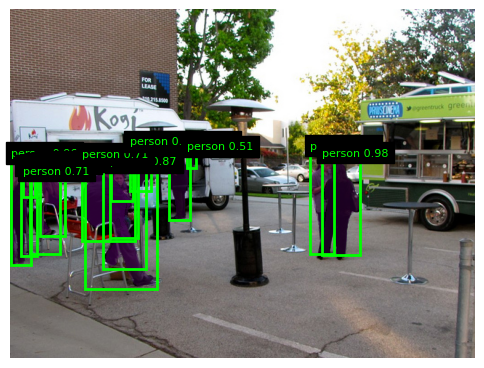


Image: 000000156292.jpg


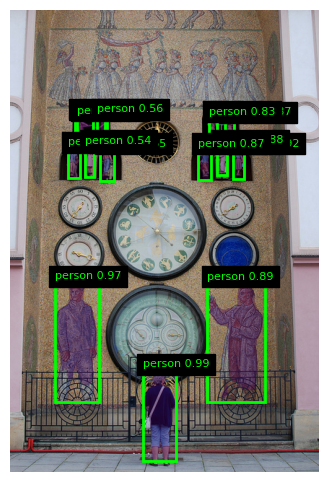


Image: 000000161032.jpg


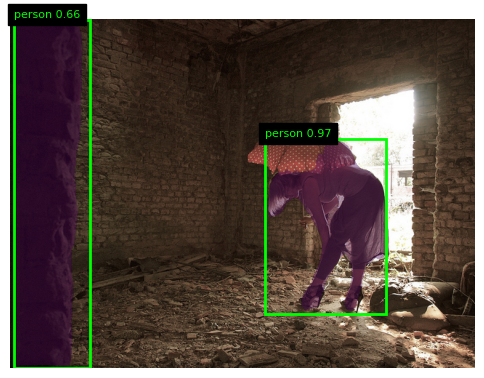

In [26]:
# List all test images
test_files = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(".jpg")])
print("Total test images:", len(test_files))
print("All test images:", test_files)

# ---- SIMPLE SLICE HERE ----
# Example: take images from index 5 to 8 (you choose numbers)
selected_test_files = test_files[8:11]
# ----------------------------

print("Selected images:", selected_test_files)

# Visualise predictions
for fname in selected_test_files:
    img_path = os.path.join(TEST_IMG_DIR, fname)
    print("\nImage:", fname)
    visualize_predictions(model, img_path, score_thresh=0.5)
